In [1]:
import sys, os
print(sys.executable)
print(os.getcwd())

C:\Users\chenr\miniforge3\envs\astropy\python.exe
C:\Users\chenr\OneDrive\Desktop\phys-134-proj


In [2]:
rootfolder=os.getcwd().replace('\\','/')
print(rootfolder)

C:/Users/chenr/OneDrive/Desktop/phys-134-proj


In [3]:
os.chdir(f"{rootfolder}/lco_data-20251202-36")
os.getcwd()

'C:\\Users\\chenr\\OneDrive\\Desktop\\phys-134-proj\\lco_data-20251202-36'

In [51]:
def imageprocessing(arr, a=1000, contrast=1, bias=0.5):
    min_im, max_im = np.min(arr), np.max(arr)
    norm = (arr - min_im) / (max_im - min_im)
    log = np.log(1 + a*norm) / np.log(1+a)
    final_data = (log- 0.5) * contrast + bias
    final_data = np.clip(final_data, 0, 1)
    return final_data

In [66]:
# we need the RA/DEC data from each observation and translate it to pixel coordinates.
import pickle
#load from pickle
with open('merged_data.pkl', 'rb') as f:
    merged_data = pickle.load(f)
#recall that the keys are the valid observations

Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -30.167703 from OBSGEO-[XYZ].
Set OBSGEO-H to     2197.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    30.680041 from OBSGEO-[XYZ].
Set OBSGEO-H to     2026.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    20.706969 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.995 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.380633 from OBSGEO-[XYZ].
Set OBSGEO-H to     1756.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272819 from OBSGEO-[XYZ].
Set OBSGEO-H to     1126.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [67]:
merged_data[list(merged_data.keys())[0]]

{'icrs': {'ra': array([77.96901145, 78.00383066, 77.98107419, 78.08611895, 77.67491618,
         77.75851002, 77.83228109, 77.64550192, 77.7778916 , 77.79665041,
         77.74453099, 78.02132324, 78.03735253, 77.99115373, 77.826763  ]),
  'dec': array([18.03399294, 18.03051053, 18.11159006, 18.13817795, 18.08610803,
         18.11167927, 18.3110055 , 18.29675712, 18.31631118, 18.41226387,
         18.41350691, 18.29639713, 18.32767694, 18.33238649, 18.41757886])},
 'image': {'x': array([ 674.51008,  515.45897,  618.67282,  137.7245 , 2021.3085 ,
         1637.122  , 1299.9491 , 2154.6617 , 1548.8365 , 1462.3786 ,
         1700.4093 ,  435.45068,  361.83888,  573.49969, 1324.5271 ]),
  'y': array([ 325.71172,  308.99125,  699.70433,  826.61105,  578.00791,
          700.31366, 1661.0504 , 1593.8816 , 1686.4079 , 2149.6571 ,
         2155.6244 , 1590.5307 , 1741.6414 , 1763.3525 , 2172.8186 ])},
 'nddata': NDData([[ 4.7827606 ,  0.3642283 , -0.9027024 , ...,  0.6471738 ,
           0.69

In [68]:
#this code is copied nearly verbatim from 3c-....ipynb

import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
for idx, key in enumerate(merged_data.keys()):
    filename = key
    print(f"Fitting Gaussians for file {idx+1} of {len(merged_data.keys())}: {filename}")
    #Gaussian2D model: amplitude, x_mean, y_mean, x_stddev, y_stddev, theta | None, cov_matrix | None
    # we'll just use the larger stdev and assume symmetric 2d gaussian later
    #using lmlsqfitter since we want a greedy fit since we're quite confident with initial guesses
    #x_mean and y_mean are the centroid positions, we already have good estimates
    
    # starting with an amplitude estimate
    # amplitude can be estimated as max pixel value in cutout - median pixel value in cutout
    # lets slice a 31 pixel cutout (+-15 pixels square) around each reference star centroid's rounded image x,y
    
    #within frame !!!!
    #array of 2d arrays, given by +- 15 pixels from center, where center is rounded x,y from merged_data
    #1 per reference star
    
    pixel_array = merged_data[filename]['nddata'].data
    offset = 30 #using 30 because asteroid is probably brighter
    
    # +1 on ends since ends are exlusive in python slicing
    x,y = merged_data[filename]['pixel_coords']
    cutout = pixel_array[round(y)-offset:round(y)+offset+1, round(x)-offset:round(x)+offset+1]
    cutout_sigma = merged_data[filename]['nddata'].uncertainty.array[round(y)-offset:round(y)+offset+1, round(x)-offset:round(x)+offset+1]
    
    amp_guess = np.max(cutout) - np.median(cutout)
    x0_guess = offset  # since cutout is centered around star, x0 and y0 are at center of cutout
    y0_guess = offset
    #sigma guess is just 2 for now
    
    #perform fit
    sigma_guess = 1.5
    
    gauss_init = models.Gaussian2D(amplitude=amp_guess,
                                    x_mean=x0_guess,
                                    y_mean=y0_guess,
                                    x_stddev=sigma_guess,
                                    y_stddev=sigma_guess)
    
    fit_p = fitting.LevMarLSQFitter()
    y_indices, x_indices = np.mgrid[0:cutout.shape[0], 0:cutout.shape[1]]   
    gauss_fit = fit_p(gauss_init, x_indices, y_indices, cutout, weights = 1/(cutout_sigma[idx] + 1e-6))
    
    # since the fits are on a cutout, the image adjustment is: fit + rounded original center - offset
        
    merged_data[filename]['asteroid_fit'] = {
        'xs_fit': gauss_fit.x_mean.value + round(merged_data[filename]['pixel_coords'][0]) - offset,
        'ys_fit': gauss_fit.y_mean.value + round(merged_data[filename]['pixel_coords'][1]) - offset,
        'sigmas_fit': (gauss_fit.x_stddev.value + gauss_fit.y_stddev.value) / 2.0
    }

Fitting Gaussians for file 1 of 33: 2025-11-25-h02-m00-s14-ms936-tfn.fits
Fitting Gaussians for file 2 of 33: 2025-11-25-h05-m00-s13-ms688-lsc.fits
Fitting Gaussians for file 3 of 33: 2025-11-25-h05-m36-s42-ms454-lsc.fits
Fitting Gaussians for file 4 of 33: 2025-11-25-h06-m06-s14-ms909-lsc.fits
Fitting Gaussians for file 5 of 33: 2025-11-25-h07-m45-s12-ms840-elp.fits
Fitting Gaussians for file 6 of 33: 2025-11-25-h08-m30-s09-ms718-elp.fits
Fitting Gaussians for file 7 of 33: 2025-11-25-h09-m06-s12-ms841-elp.fits
Fitting Gaussians for file 8 of 33: 2025-11-25-h10-m06-s14-ms367-elp.fits
Fitting Gaussians for file 9 of 33: 2025-11-25-h11-m06-s18-ms072-elp.fits
Fitting Gaussians for file 10 of 33: 2025-11-25-h12-m47-s39-ms526-ogg.fits
Fitting Gaussians for file 11 of 33: 2025-11-25-h13-m06-s13-ms287-ogg.fits
Fitting Gaussians for file 12 of 33: 2025-11-25-h14-m06-s15-ms196-ogg.fits
Fitting Gaussians for file 13 of 33: 2025-11-25-h23-m02-s40-ms929-tfn.fits
Fitting Gaussians for file 14 of 3

In [69]:
merged_data[list(merged_data.keys())[20]]

{'icrs': {'ra': array([77.96901145, 78.00383066, 77.98107419, 78.08611895, 77.67491618,
         77.75851002, 77.83228109, 77.64550192, 77.7778916 , 77.79665041,
         77.74453099, 78.02132324, 78.03735253, 77.99115373, 77.826763  ]),
  'dec': array([18.03399294, 18.03051053, 18.11159006, 18.13817795, 18.08610803,
         18.11167927, 18.3110055 , 18.29675712, 18.31631118, 18.41226387,
         18.41350691, 18.29639713, 18.32767694, 18.33238649, 18.41757886])},
 'image': {'x': array([ 664.21278,  503.75138,  608.18918,  124.61185, 2017.2387 ,
         1631.7541 , 1293.2823 , 2151.7882 , 1542.3273 , 1457.0857 ,
         1695.4802 ,  424.82436,  351.65201,  563.43087, 1317.8683 ]),
  'y': array([ 357.5697 ,  341.53187,  733.31929,  861.96362,  609.77533,
          734.16643, 1697.901  , 1629.6401 , 1724.0494 , 2187.5454 ,
         2194.333  , 1628.4927 , 1780.0636 , 1801.374  , 2211.8241 ])},
 'nddata': NDData([[  3.214271  ,   1.7486069 ,  -1.0729355 , ...,
            2.111133  ,  

Analysis of sigmas

In [70]:
sigmas = np.array([merged_data[filename]['asteroid_fit']['sigmas_fit'] for filename in merged_data.keys()])

mean_sigmas = np.mean(sigmas)
std_sigmas = np.std(sigmas)
print(f"Mean sigma: {mean_sigmas}, Stddev sigma: {std_sigmas}")
sigmas

Mean sigma: 1.4316927092751015, Stddev sigma: 0.3345528621124657


array([1.04760863, 1.30490481, 1.88132929, 1.46930909, 1.05794221,
       1.99014504, 1.56610582, 1.15491566, 1.68579133, 1.26920159,
       1.24851817, 1.26300611, 1.63771139, 1.82247629, 1.23504166,
       1.32243786, 1.18524278, 1.22449956, 1.24127271, 1.06044118,
       1.24894483, 1.46498931, 1.11242434, 0.99077476, 0.96740335,
       1.52506668, 1.86417842, 1.76777109, 1.8293942 , 2.31265139,
       1.94100793, 1.33496858, 1.21838337])

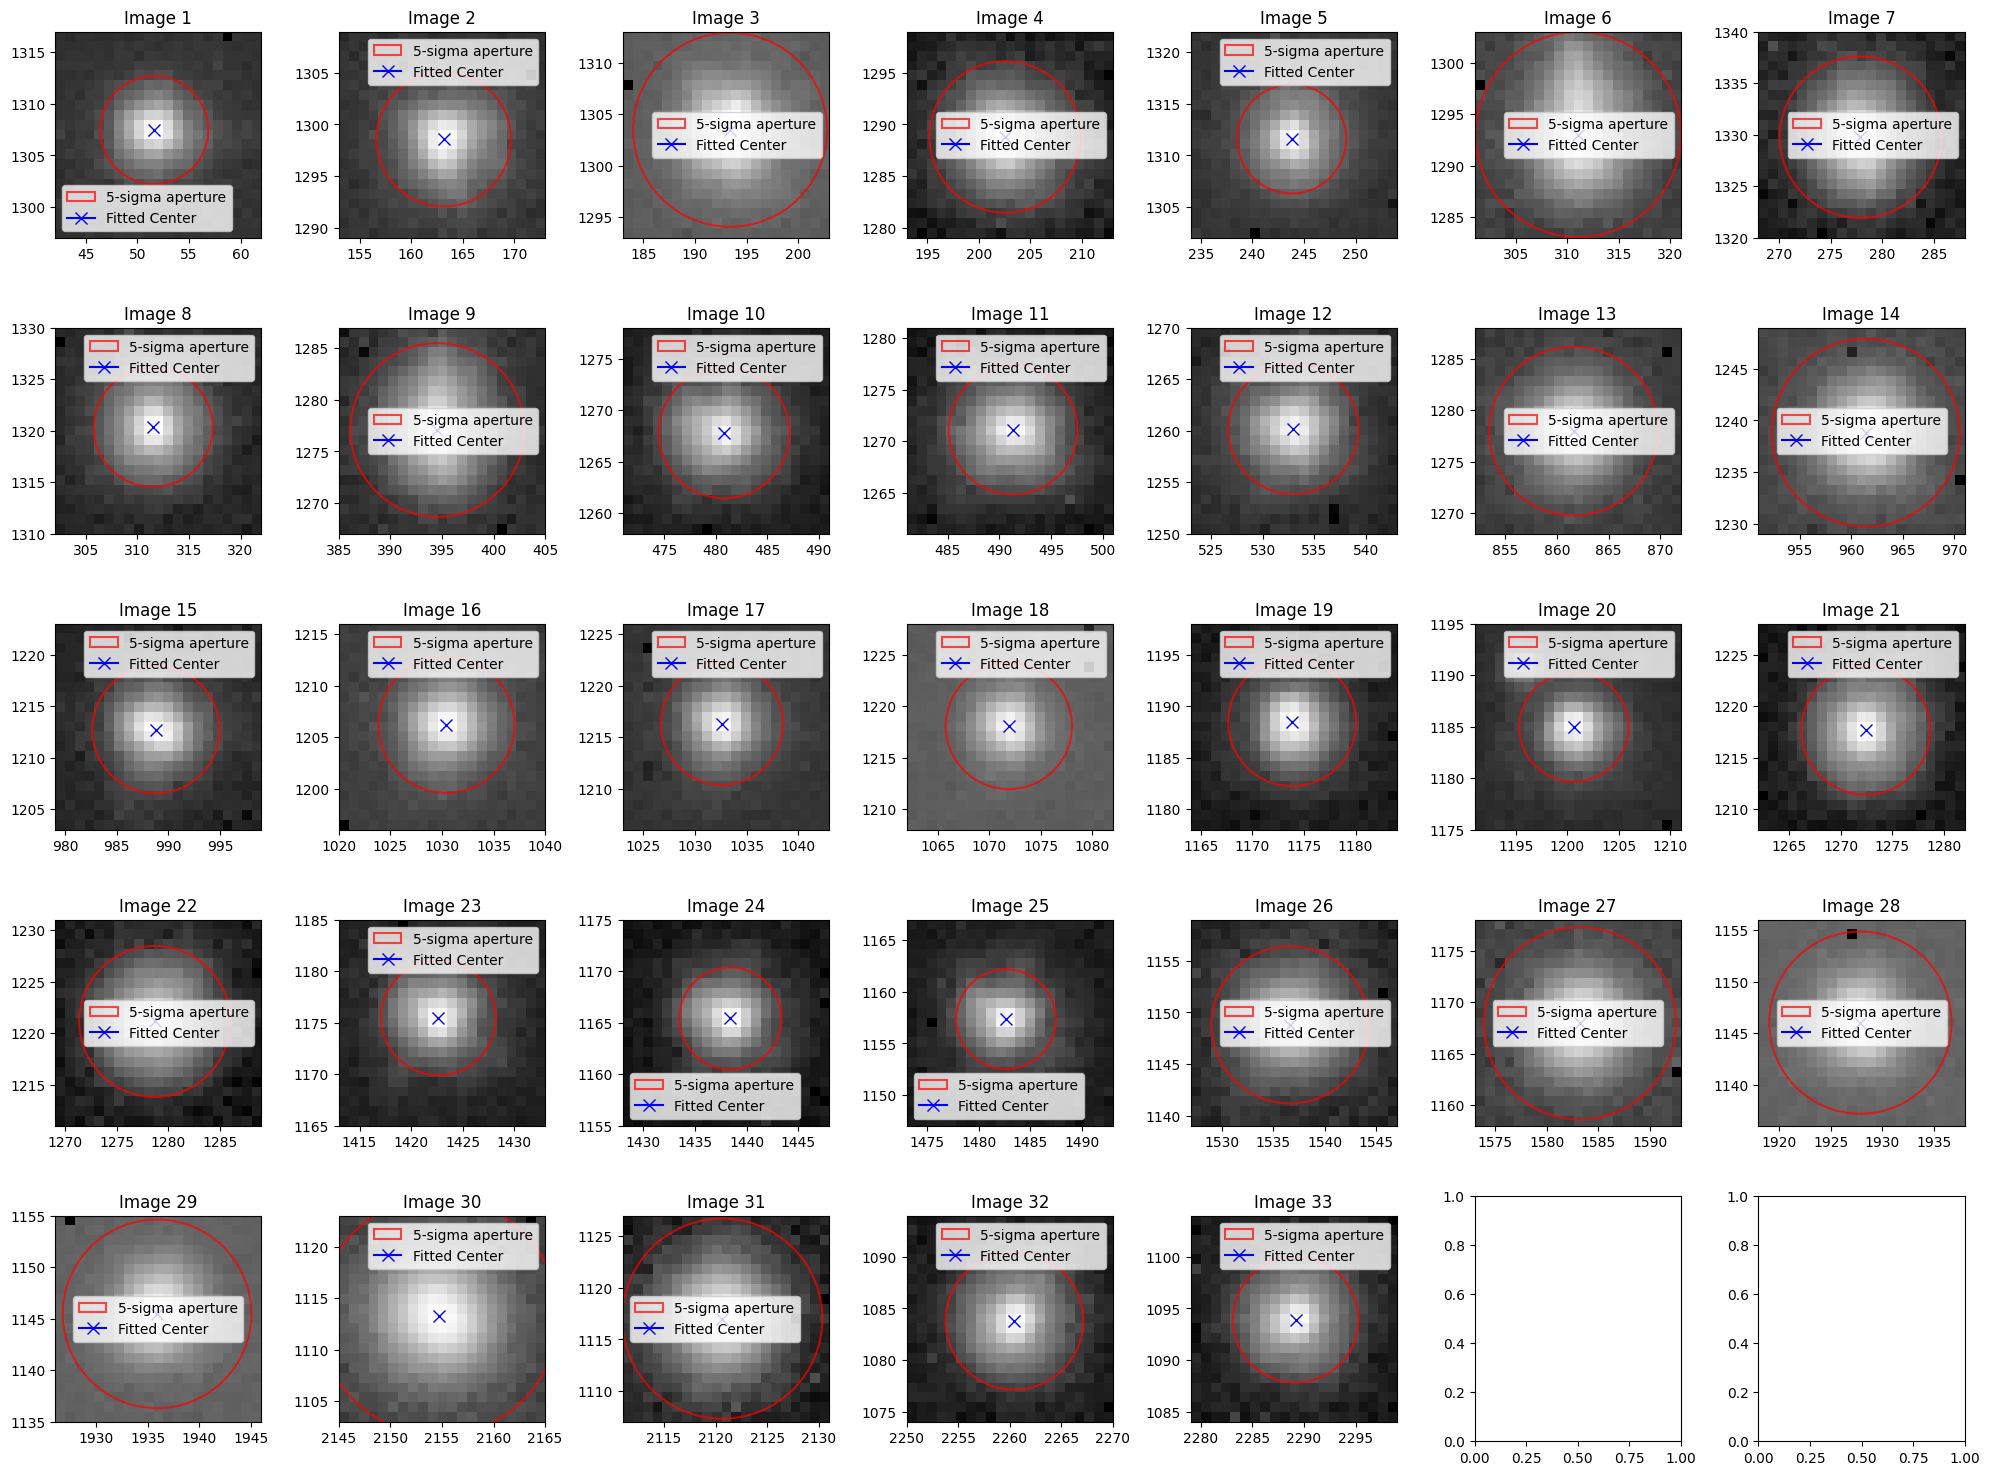

In [71]:
#lets visualize all of the asteroids
# 33 images, lets do a 5*7 grid
from photutils.aperture import CircularAperture
fig, axs = plt.subplots(5,7, figsize=(20,15))
axs = axs.flatten()
for idx, key in enumerate(merged_data.keys()):
    filename = key
    pixel_array = merged_data[filename]['nddata'].data
    x_fit = (merged_data[filename]['asteroid_fit']['xs_fit'])
    y_fit = (merged_data[filename]['asteroid_fit']['ys_fit'])
    
    from astropy.nddata.utils import Cutout2D
    position = (x_fit, y_fit)
    cutout = Cutout2D(pixel_array, position, 21)
    #circle at 3*sigma
    sigma_fit = merged_data[filename]['asteroid_fit']['sigmas_fit']
    bbox = cutout.bbox_original
    circle = CircularAperture((position), r=5*sigma_fit)
    circle.plot(ax=axs[idx], color='red', label='5-sigma aperture', lw=1.5, alpha=0.7)
    #draw dot at fitted center
    axs[idx].plot(x_fit, y_fit, marker='x', color='blue', label='Fitted Center', markersize=8)
    axs[idx].imshow(imageprocessing(cutout.data), cmap='gray', origin='lower', extent = [bbox[1][0], bbox[1][1], bbox[0][0], bbox[0][1]])
    axs[idx].set_title(f"Image {idx+1}")
    axs[idx].legend()
plt.tight_layout()

plt.show()

Data Looks Good

## Further sigma checks

In [72]:
np.min(sigmas), mean_sigmas, np.max(sigmas), std_sigmas

(np.float64(0.9674033543625076),
 np.float64(1.4316927092751015),
 np.float64(2.3126513924245193),
 np.float64(0.3345528621124657))

In [73]:
worst_sigma, idx_worst = np.max(sigmas), np.argmax(sigmas)
worst_sigma, idx_worst

(np.float64(2.3126513924245193), np.int64(29))

# Asteroid Aperture Photometry

In [77]:
#copied code again
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats
from astropy.stats import SigmaClip


rad_innerap=5*worst_sigma
rad_innerann=7*worst_sigma
rad_outerann=9*worst_sigma

apertures = [CircularAperture( ( merged_data[file]['asteroid_fit']['xs_fit'], merged_data[file]['asteroid_fit']['ys_fit'] )
                               ,r = rad_innerap) 
             for file 
             in merged_data.keys()]
annulus_apertures = [CircularAnnulus((merged_data[file]['asteroid_fit']['xs_fit'], merged_data[file]['asteroid_fit']['ys_fit'])
                                     , r_in=rad_innerann
                                     , r_out=rad_outerann) 
                     for file 
                     in merged_data.keys()]


sigclip = SigmaClip(sigma=3.0, maxiters=10)

#aperture
aper_stats_list = [ApertureStats(merged_data[filename]['nddata'].data, apertures[idx], sigma_clip=None, error = merged_data[filename]['nddata'].uncertainty.array)
                   for idx, filename in enumerate(merged_data.keys())]
#anulus
annulus_stats_list = [ApertureStats(merged_data[filename]['nddata'].data, annulus_apertures[idx], sigma_clip=sigclip, error = merged_data[filename]['nddata'].uncertainty.array)
                      for idx, filename in enumerate(merged_data.keys())]
#estimator for total background in aperture from annulus stats
total_anulus_list = [annulus_stats.median * aper_stats.sum_aper_area.value 
                         for annulus_stats, aper_stats 
                         in zip(annulus_stats_list, aper_stats_list)]
#estimator of total background sigma in aperture from annulus stats
total_bkg_sigma_list = [annulus_stats.mad_std * np.sqrt(np.pi / 2 / annulus_stats.sum_aper_area.value) * aper_stats.sum_aper_area.value 
                            for annulus_stats, aper_stats 
                            in zip(annulus_stats_list, aper_stats_list)]

#Final Integrated Fluxes and Errors after Estimated Background Subtraction
apersum_subbkg_list  = [aper_stats.sum - total_anulus for aper_stats, total_anulus in zip(aper_stats_list, total_anulus_list)]
apersum_subbkg_sigma_list = [np.sqrt(aper_stats.sum_err**2 + total_bkg_sigma**2)
                            for aper_stats, total_bkg_sigma in zip(aper_stats_list, total_bkg_sigma_list)]

apersum_np = np.array(apersum_subbkg_list)
apersum_sigma_np = np.array(apersum_subbkg_sigma_list)
norms_np = np.array([merged_data[filename]['R_i'] for filename in merged_data.keys()])
norms_sigma_np = np.array([merged_data[filename]['R_sigma_i'] for filename in merged_data.keys()])


Before we treat the values as final, we need to normalize them first.

$$F_{final, i} = \frac{F_{ast, i}}{R_i}$$

Again, by the general taylor expansion rule for variances (assuming low covariance contribution due to large samples):

$$ \frac{Var(F_{final,i})}{F_{final, i}^2} = \frac{Var(F_{ast, i})}{F_{ast, i}^2} + \frac{Var(R_i)}{R_i^2}$$

Which allows us to calculate the uncertainty of $F_{final,i}$

In [78]:
#taking advantage of numpy array broadcasting

# F final i
apersum_normadj_np = apersum_np / norms_np
apersum_normadj_sigma_np = apersum_normadj_np * np.sqrt( (apersum_sigma_np / apersum_np)**2 + (norms_sigma_np / norms_np)**2 )

apersum_normadj_np, apersum_normadj_sigma_np

(array([ 99589.73559374,  99908.15214798,  99141.77117302, 101139.75292607,
         99517.95389982, 101221.1760282 , 101321.69369725,  99154.38976674,
        107206.67141916,  95441.26803284,  98749.80538918,  98251.40171169,
        104710.92270527, 106940.40794719,  94167.79134745, 101010.19839154,
         99507.59864973,  99774.17327856,  95825.15390593, 104331.05443342,
        106856.35993353, 106406.98365292,  98865.76327758, 105684.9078239 ,
        101794.59252002, 100452.81150999,  98664.24452068,  99758.69644327,
        100638.71018039, 112588.41438079, 111083.33336483, 102924.11851742,
        102972.4524085 ]),
 array([ 625.38358615,  601.44025526,  639.51694584,  613.57034846,
         802.6061415 ,  936.47272593,  833.8442714 ,  825.13651532,
        1034.4116275 ,  532.50723875,  558.68530853,  592.59494552,
         860.89646448, 1065.20461559,  510.09708371,  581.99877186,
         693.47875283, 3621.84724933,  536.42648689,  587.32957438,
         824.32963134,  8

Processing file 1 of 33: 2025-11-25-h02-m00-s14-ms936-tfn.fits
Processing file 2 of 33: 2025-11-25-h05-m00-s13-ms688-lsc.fits
Processing file 3 of 33: 2025-11-25-h05-m36-s42-ms454-lsc.fits
Processing file 4 of 33: 2025-11-25-h06-m06-s14-ms909-lsc.fits
Processing file 5 of 33: 2025-11-25-h07-m45-s12-ms840-elp.fits
Processing file 6 of 33: 2025-11-25-h08-m30-s09-ms718-elp.fits
Processing file 7 of 33: 2025-11-25-h09-m06-s12-ms841-elp.fits
Processing file 8 of 33: 2025-11-25-h10-m06-s14-ms367-elp.fits
Processing file 9 of 33: 2025-11-25-h11-m06-s18-ms072-elp.fits
Processing file 10 of 33: 2025-11-25-h12-m47-s39-ms526-ogg.fits
Processing file 11 of 33: 2025-11-25-h13-m06-s13-ms287-ogg.fits
Processing file 12 of 33: 2025-11-25-h14-m06-s15-ms196-ogg.fits
Processing file 13 of 33: 2025-11-25-h23-m02-s40-ms929-tfn.fits
Processing file 14 of 33: 2025-11-25-h23-m35-s17-ms210-cpt.fits
Processing file 15 of 33: 2025-11-26-h00-m55-s17-ms907-tfn.fits
Processing file 16 of 33: 2025-11-26-h01-m55-s17-

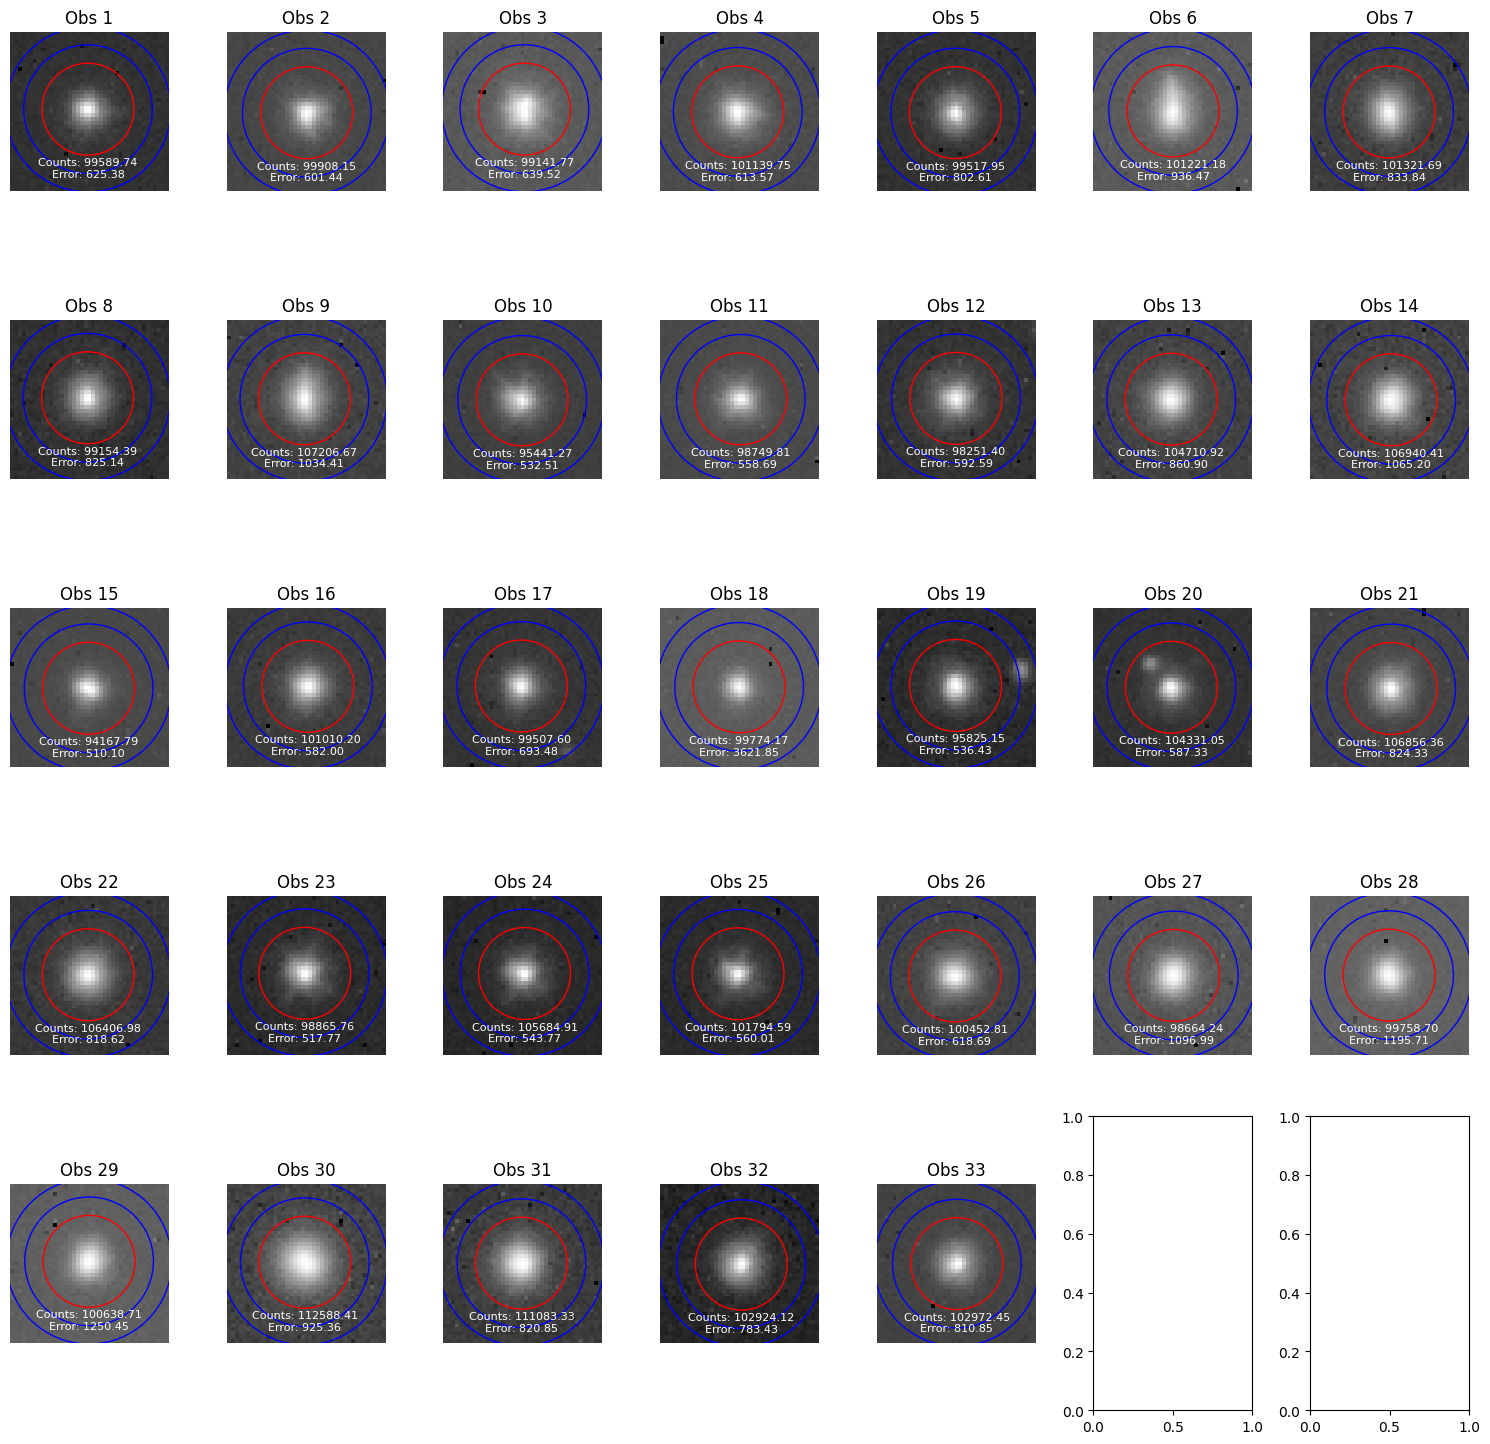

In [81]:
fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(15,15))
#draw image and overplot apertures and annuli
for idx, filename in enumerate(merged_data.keys()):
    print(f"Processing file {idx+1} of {len(merged_data)}: {filename}")
    ax = axes.flatten()[idx]
    pixel_array = merged_data[filename]['nddata'].data
    offset = 20
    cutout = Cutout2D(pixel_array, (positions[idx][0], positions[idx][1]), 2*offset+1)
    bbox = cutout.bbox_original
    ax.imshow(imageprocessing(cutout.data), cmap='gray', origin='lower', extent = [bbox[1][0], bbox[1][1], bbox[0][0], bbox[0][1]])
    #label the flux and error on the bottom of each plot
    ax.text(positions[idx][0], positions[idx][1] - offset, f"Counts: {apersum_normadj_np[idx]:.2f}\nError: {apersum_normadj_sigma_np[idx]:.2f}\n", color='white', fontsize=8, ha='center')
    apertures[idx].plot(ax=ax, color='red', lw=1)
    annulus_apertures[idx].plot(ax=ax, color='blue', lw=1)
    ax.set_title(f"Obs {idx+1}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [85]:
# save apersum_normadj_np and apersum_normadj_sigma_np to merged_data
for idx, filename in enumerate(merged_data.keys()):
    merged_data[filename]['asteroid_flux_normadj'] = apersum_normadj_np[idx]
    merged_data[filename]['asteroid_flux_normadj_sigma'] = apersum_normadj_sigma_np[idx]
    
#save to pickle
with open('merged_data.pkl', 'wb') as f:
    pickle.dump(merged_data, f)

In [86]:
merged_data[list(merged_data.keys())[0]]

{'icrs': {'ra': array([77.96901145, 78.00383066, 77.98107419, 78.08611895, 77.67491618,
         77.75851002, 77.83228109, 77.64550192, 77.7778916 , 77.79665041,
         77.74453099, 78.02132324, 78.03735253, 77.99115373, 77.826763  ]),
  'dec': array([18.03399294, 18.03051053, 18.11159006, 18.13817795, 18.08610803,
         18.11167927, 18.3110055 , 18.29675712, 18.31631118, 18.41226387,
         18.41350691, 18.29639713, 18.32767694, 18.33238649, 18.41757886])},
 'image': {'x': array([ 674.51008,  515.45897,  618.67282,  137.7245 , 2021.3085 ,
         1637.122  , 1299.9491 , 2154.6617 , 1548.8365 , 1462.3786 ,
         1700.4093 ,  435.45068,  361.83888,  573.49969, 1324.5271 ]),
  'y': array([ 325.71172,  308.99125,  699.70433,  826.61105,  578.00791,
          700.31366, 1661.0504 , 1593.8816 , 1686.4079 , 2149.6571 ,
         2155.6244 , 1590.5307 , 1741.6414 , 1763.3525 , 2172.8186 ])},
 'nddata': NDData([[ 4.7827606 ,  0.3642283 , -0.9027024 , ...,  0.6471738 ,
           0.69